In [66]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
# Data Vis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
#sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')

In [67]:
# Define IAM role
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()
print(role)
sess = sagemaker.Session()
#bucket = 'hr-attrition'
bucket = 'hr-attrition'
prefix = ''

arn:aws:iam::420696774360:role/service-role/AmazonSageMaker-ExecutionRole-20181125T220006


In [68]:
data_key_train = 'hr_attrition_train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key_train)

train=pd.read_csv(data_location)


In [69]:
train.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,1,0.38,0.53,2,157,3,0,1,0,sales,low
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium
3,4,0.72,0.87,5,223,5,0,1,0,sales,low
4,5,0.37,0.52,2,159,3,0,1,0,sales,low


In [70]:
data_key_test = 'hr_attrition_test.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
data_location_test = 's3://{}/{}'.format(bucket, data_key_test)
test = pd.read_csv(data_location_test)

In [71]:
pd.set_option('display.max_columns',999)
test.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,13001,0.62,0.94,4,252,4,0,0,accounting,low
1,13002,0.38,0.52,2,171,3,0,0,accounting,medium
2,13003,0.80,0.77,4,194,3,0,0,accounting,medium
3,13004,0.61,0.42,3,104,2,0,0,hr,medium
4,13005,0.61,0.56,4,176,3,0,0,hr,medium


In [72]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [73]:
missing_data(train).head(10)
missing_data(test).head(10)

,Total,Percent
salary,0,0.0
sales,0,0.0
promotion_last_5years,0,0.0
Work_accident,0,0.0
time_spend_company,0,0.0
average_montly_hours,0,0.0
number_project,0,0.0
last_evaluation,0,0.0
satisfaction_level,0,0.0
id,0,0.0


In [42]:
# Get target
target = 'left'

# Get quantitative features and delete the unnccessary features
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('id')


# Get categorical features
categorical = [f for f in train.columns if train.dtypes[f] == 'object']

train_y = train['left']

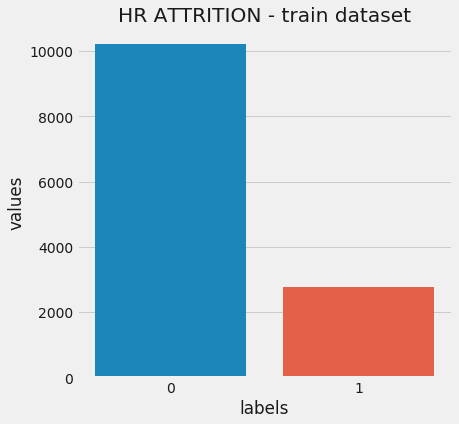

In [43]:
temp = train["left"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('HR ATTRITION - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

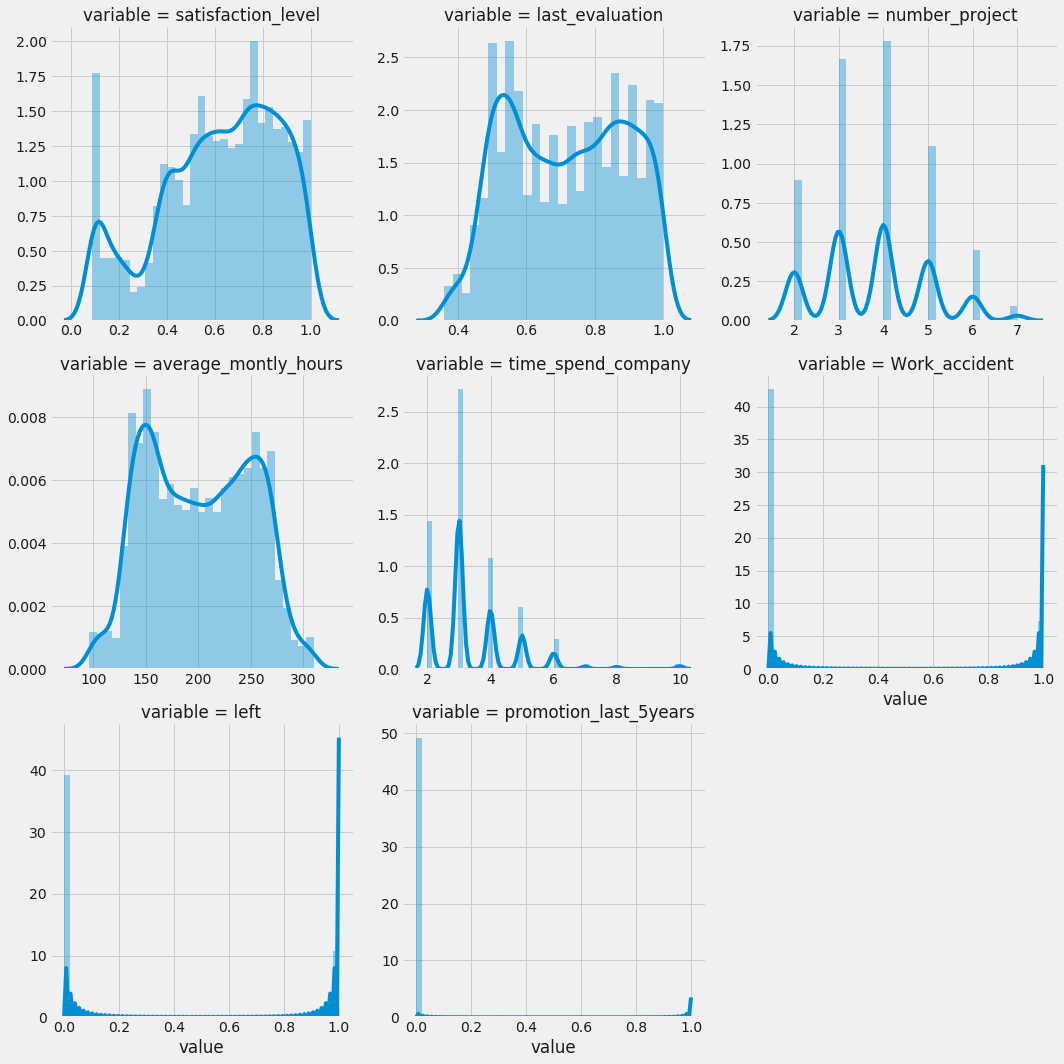

In [74]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value")

In [75]:
satisfaction_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
train['satisfaction_binned'] = pd.cut(train['satisfaction_level'], satisfaction_bins)
evaluation_bins = [ 0.3, 0.5, 0.7, 0.8, 0.9,1.0]
train['evaluation_binned'] = pd.cut(train['last_evaluation'], evaluation_bins)
monthly_hours_bin = [ 0, 100, 150, 200, 250, 300, 350]
train['monthly_hours_binned'] = pd.cut(train['average_montly_hours'], monthly_hours_bin)

In [76]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of employees': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'left']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='left', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of employees",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='left', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [77]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[train['left'] != 0]
    t0 = train.loc[train['left'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="left = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="left = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

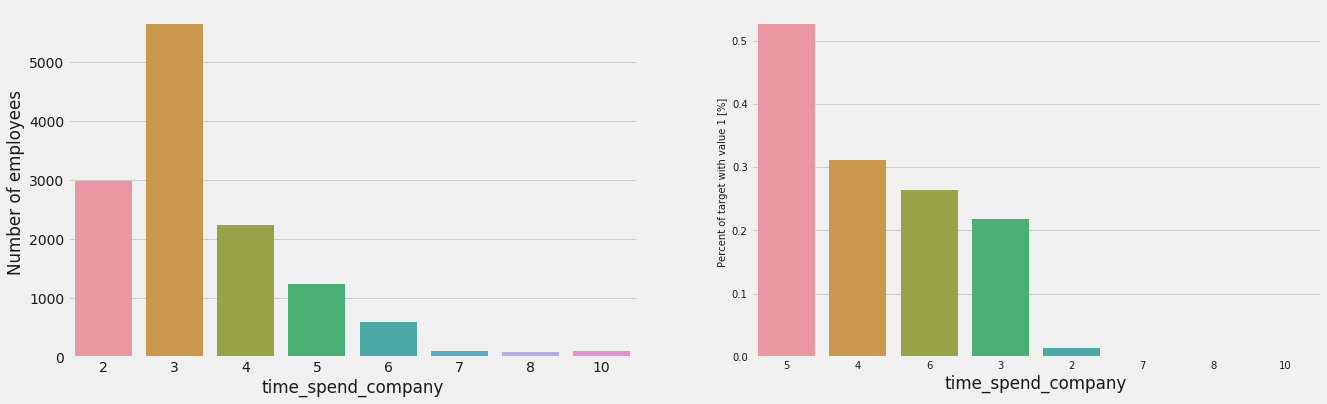

In [78]:
plot_stats('time_spend_company')

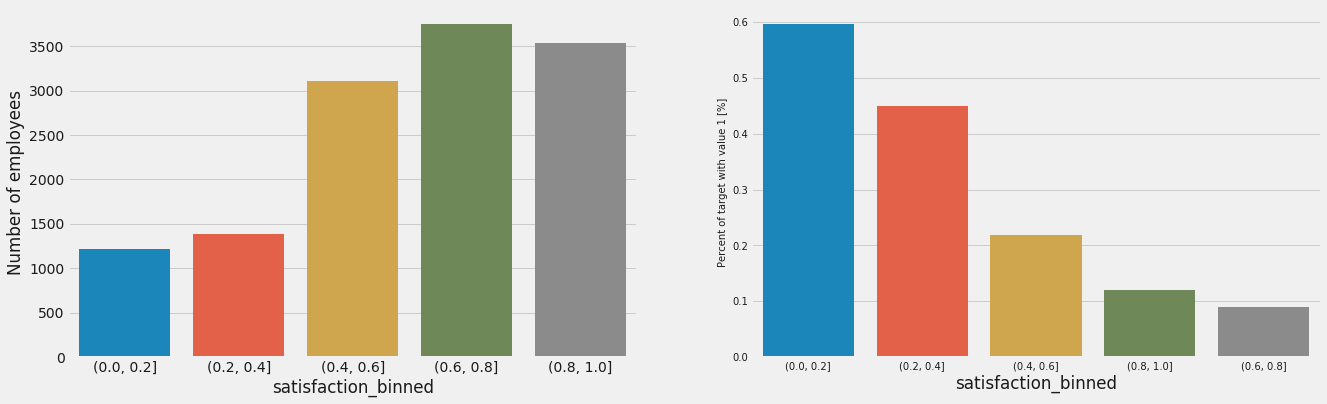

In [79]:
plot_stats('satisfaction_binned')

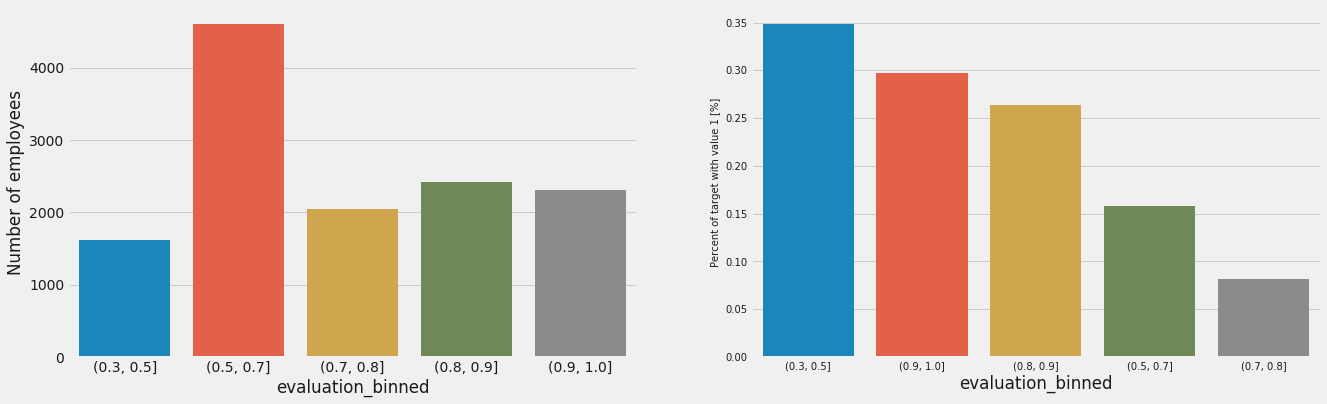

In [80]:
plot_stats('evaluation_binned')

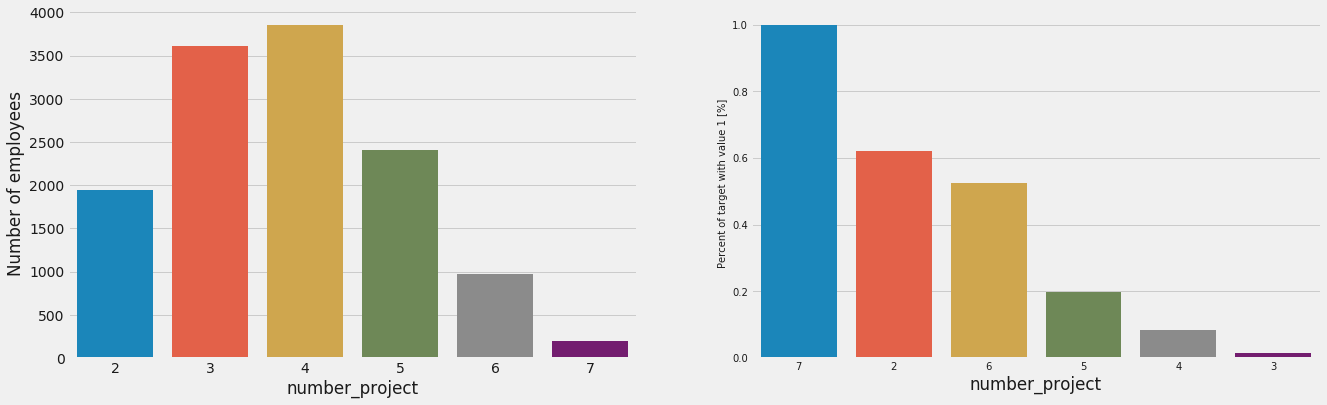

In [81]:
plot_stats('number_project')

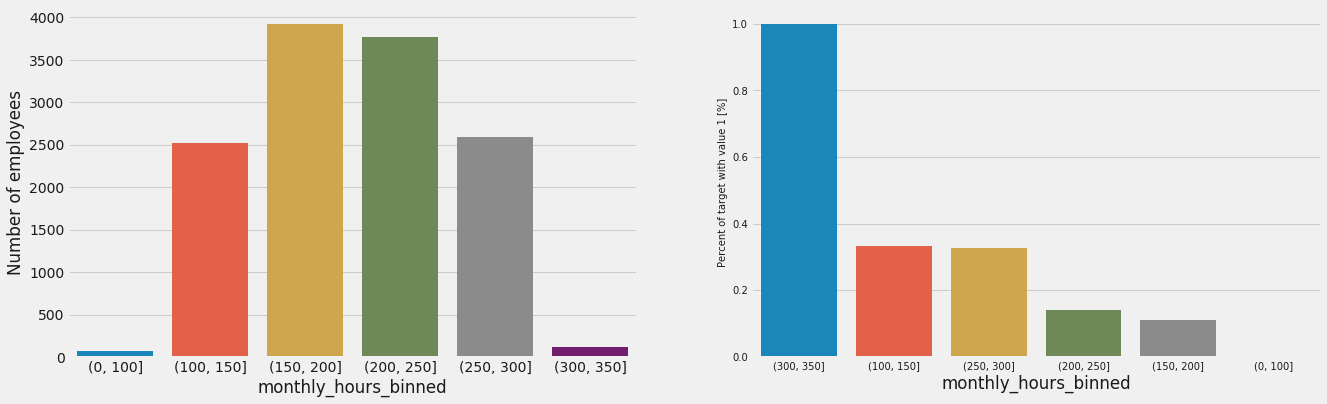

In [82]:
plot_stats('monthly_hours_binned')

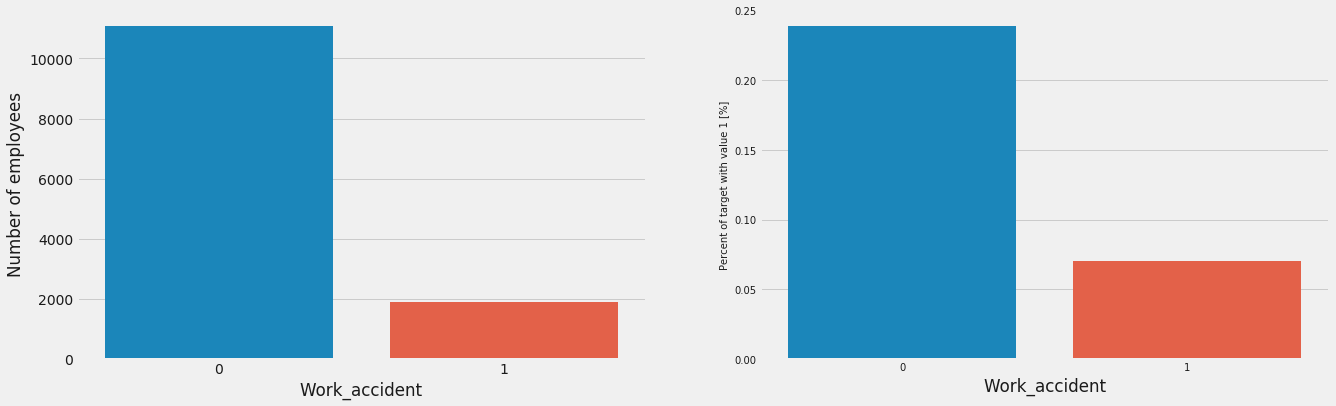

In [83]:
plot_stats('Work_accident')

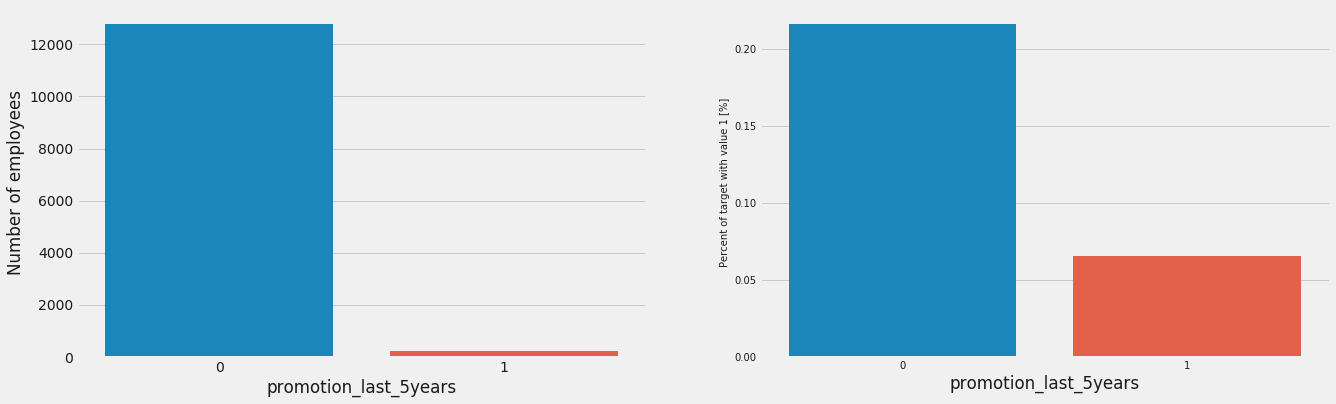

In [84]:
plot_stats('promotion_last_5years')

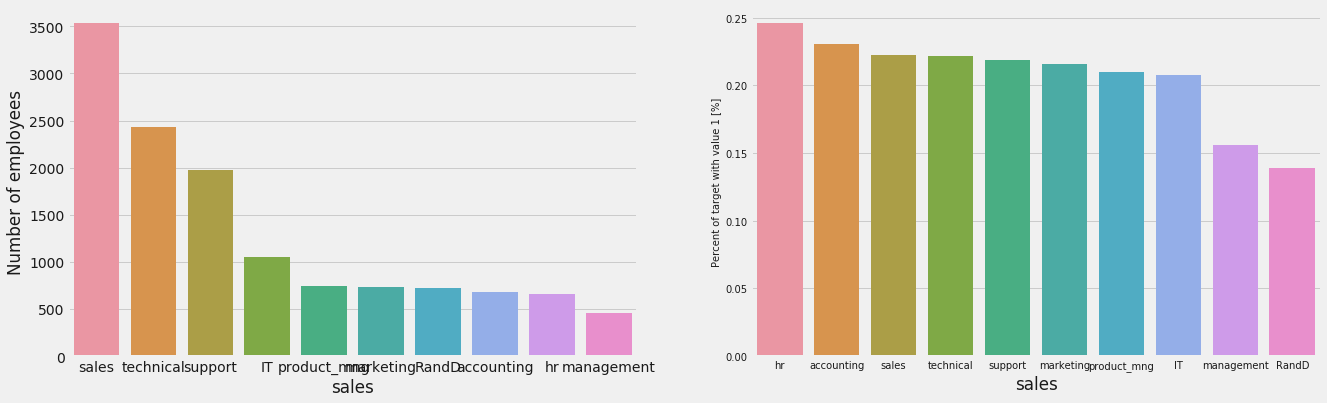

In [85]:
plot_stats('sales')

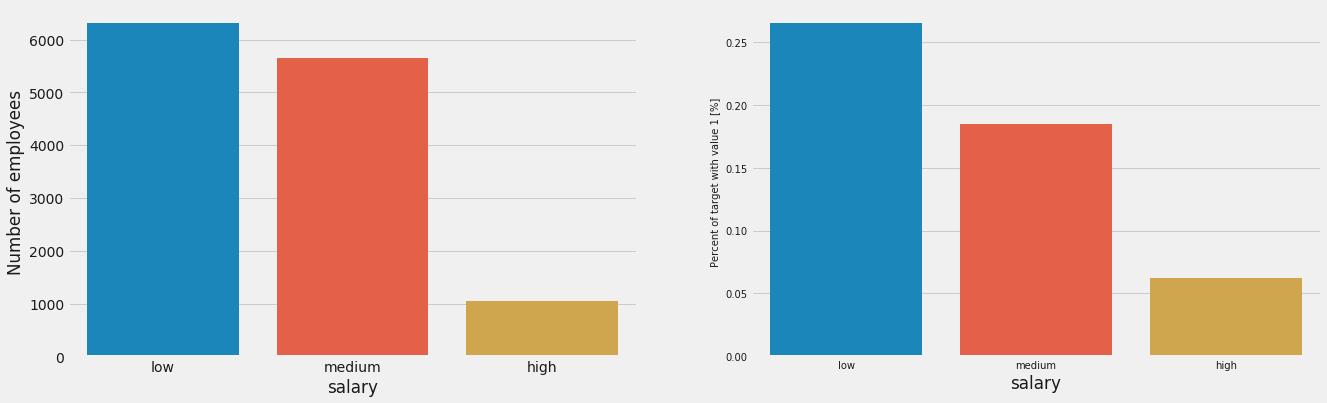

In [86]:
plot_stats('salary')

In [87]:
model_data = train

In [88]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [89]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [57]:
import lightgbm as lgbm

train_y = train['left']
train = train.drop('left', axis=1)
train = train.drop('id', axis=1)
test_id = test['id']
test = test.drop('id', axis=1)
lgbc2 = lgbm.sklearn.LGBMClassifier( 
  boosting_type = 'gbdt', 
  objective = 'binary', 
     
    is_unbalance = 'true',
  #  metric =  'roc_auc', 
 #   scale_pos_weight = 0.2,

    max_depth = 7, 
 num_leaves = 80 , 
 learning_rate = 0.05, 
 class_weight = 'balanced', 
     verbose = -1, 
  min_gain_to_split = 0
) 


train = pd.get_dummies(train)
test = pd.get_dummies(test)
#train, test = train.align(test, join = 'inner', axis = 1)
train_final = train
test_final = test
train_final.head()
train_x = train_final.as_matrix()
test_x = test_final.as_matrix()

lgbc2.fit(train_x, train_y)

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbc2.feature_importances_,train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')